<a href="https://colab.research.google.com/github/fedhere/FASTlab/blob/master/test/testsnr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/FoxFortino/SCS.git


Cloning into 'SCS'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 381 (delta 13), reused 16 (delta 7), pack-reused 358
Receiving objects: 100% (381/381), 381.52 MiB | 30.53 MiB/s, done.
Resolving deltas: 100% (190/190), done.
Updating files: 100% (67/67), done.


In [ ]:
#cd SCS

In [ ]:
#!git pull

In [ ]:
import sys
sys.path.insert(0, "scs/")


In [ ]:
!pip install tensorflow_addons

In [ ]:
cd /content/SCS/scs

/content/SCS/scs


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.signal import savgol_filter
from scipy import optimize as opt
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Nadam

from tensorflow_addons.metrics import F1Score

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



In [ ]:

# My packages
sys.path.insert(0, "/content/SCS/scs/")
from importlib import reload  # Python 3.4+

import data_degrading as dd
reload(dd)
import data_preparation as dp
import data_augmentation as da
from prepare_datasets_for_training import extract
import scs_config

sys.path.insert(0, "/content/SCS/scs/models/")
import feed_forward
# import transformer_encoder

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

PLOT = False
PLOT = True
TESTING = False
# TESTING = True

In [ ]:



def get_noise_scale_arr():
    noise_scale_arr = np.linspace(0, 10, num=101)
    return noise_scale_arr


def clean_data(df_C, df_R, phase_range, ptp_range, wvl_range):
    if not df_C is None:
      df_CP = dp.preproccess_dataframe(
          df_C,
          phase_range=phase_range,
          ptp_range=ptp_range,
          wvl_range=wvl_range,
      )
    df_RP = dp.preproccess_dataframe(
        df_R,
        phase_range=phase_range,
        ptp_range=ptp_range,
        wvl_range=wvl_range,
    )
    if  df_C is None:
      return df_RP, df_RP
    return df_CP, df_RP


def split_train_test(df_CP, df_RP, train_frac, rng):
    df_CP_trn, df_CP_tst = dp.split_data(df_CP, train_frac, rng)
    df_RP_trn, df_RP_tst = dp.split_data(df_RP, train_frac, rng)
    return df_CP_trn, df_CP_tst, df_RP_trn, df_RP_tst


def augment_training_set(df_CP_trn, df_RP_trn, rng, wvl_range, spike_scale, max_spikes):
    df_CPA_trn = da.augment(
        df_CP_trn,
        rng,
        wvl_range=wvl_range,
        noise_scale=0,
        spike_scale=spike_scale,
        max_spikes=max_spikes,
    )
    df_RPA_trn = da.augment(
        df_RP_trn,
        rng,
        wvl_range=wvl_range,
        noise_scale=0,
        spike_scale=spike_scale,
        max_spikes=max_spikes,
    )
    return df_CPA_trn, df_RPA_trn


def get_model(input_shape, num_classes):
    model = feed_forward.model(
        input_shape,
        num_classes,
        [1024, 1024, 1024],
        activation="relu",
        dropout=0.1,
    )
    return model


def invertrfftfreq(x, bs):
    """ this utility function helps making the x axis in the plots interpretable; invert rfft"""
    freq = np.fft.rfftfreq(len(x))
    N = len(freq) * 2
    if len(x) % 2:
        return np.arange(0, max(freq * N * bs) * 2, bs)
    else:
        return np.arange(0, max(freq * N * bs) * 2 - 2 * bs, bs)


def binspec(wvl, flux, wstart, wend, wbin):
    nlam = (wend - wstart) / wbin + 1
    nlam = int(np.ceil(nlam))
    outlam = np.arange(nlam) * wbin + wstart
    answer = np.zeros(nlam)
    interplam = np.unique(np.concatenate((wvl, outlam)))
    interpflux = np.interp(interplam, wvl, flux)

    for i in np.arange(0, nlam - 1):
        cond = np.logical_and(interplam >= outlam[i], interplam <= outlam[i+1])
        w = np.where(cond)
        if len(w) == 2:
            answer[i] = 0.5*(np.sum(interpflux[cond])*wbin)
        else:
            answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])

    answer[nlam - 1] = answer[nlam - 2]
    cond = np.logical_or(outlam >= max(wvl), outlam < min(wvl))
    answer[cond] = 0
    return answer/wbin, outlam

def inject_noise(noise_scale, plot=False, recalculate=False):
    # do not change the noise
    if float(noise_scale) == 0:
        print("no noise manipulation")
        df = dp.load_dataset("../data/raw/sn_data.parquet")

        return df
    else:
        df = dp.load_dataset("../data/raw/sn_clean.parquet")

        data = dp.extract_dataframe(df)
        index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = data

        noise = dp.read_noise_dataset()
        if TESTING:
            noise = noise[:10]
    # add noise to clean flux
    print("noise: ", float(noise_scale))
    fluxes_noise = fluxes + noise * float(noise_scale)  # (fluxes, noise_scale, rng)

    if plot:
        for i in range(10):
            plt.plot(fluxes[i])
            plt.plot(fluxes_noise[i])
    # reset df with modified flux
    df.loc[:, flux_columns] = fluxes_noise
    return df


In [ ]:
def main(noise_scale):
    df_raw = inject_noise(noise_scale, recalculate=False)
    wvl = df_raw.filter(regex="\d+").columns.values.astype(float)
    if PLOT:
        plt.plot(wvl, df_raw.iloc[10, 5:], label="pre degraded?")
        plt.legend()

    rng = np.random.RandomState(1415)

    R = 100
    #if PLOT:
    #    plt.plot(df_raw.iloc[0, 5:], label="degraded?")
    #    plt.legend()
    #    plt.title(f"ns={noise_scale}")
    #    plt.show()
    print("now clean")
    phase_range = (-20, 50)
    ptp_range = (0.1, 100)
    wvl_range = (4500, 7000)
    df_CP, df_RP = clean_data(None, df_raw, phase_range, ptp_range, wvl_range)
    wvl = df_RP.filter(regex="\d+").columns.values.astype(float)

    print("now lower res")
    df_C, df_R = dd.degrade_dataframe(R, df_RP, plot=True)
    return df_R, df_R
    if PLOT:
        plt.plot(wvl, df_CP.iloc[10, 5:], label="cleaned?")
        plt.legend()
        plt.title(f"ns={noise_scale}")
        plt.show()

    train_frac = 0.50

    print("split")
    df_CP_trn, df_CP_tst, df_RP_trn, df_RP_tst = split_train_test(
        df_C, df_R, train_frac, rng
    )

    spike_scale = 3
    max_spikes = 5
    print("augmentation")

    df_CPA_trn, df_RPA_trn = augment_training_set(
        df_CP_trn, df_RP_trn, rng, wvl_range, spike_scale, max_spikes
    )
    print("train test split")
    return df_RPA_trn, df_RP_tst

no noise manipulation
now clean
now lower res


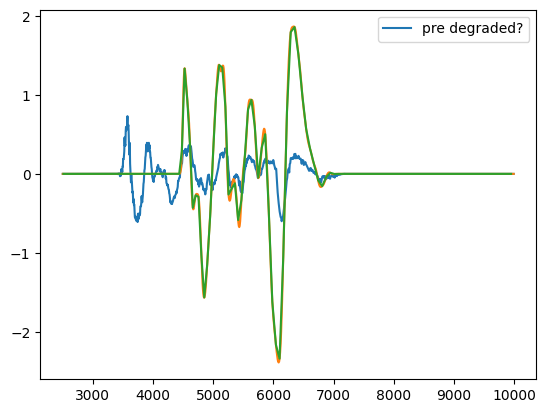

noise:  1.0
now clean
now lower res


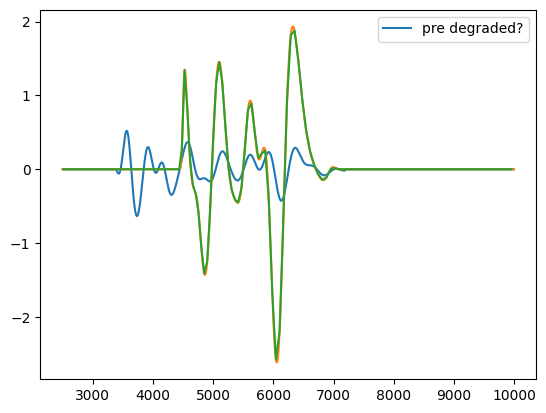

noise:  2.0
now clean
now lower res


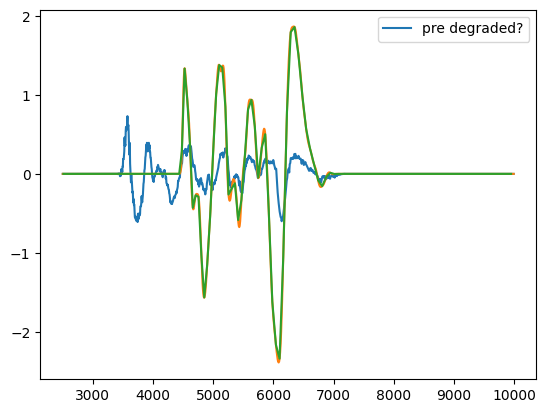

noise:  3.0
now clean
now lower res


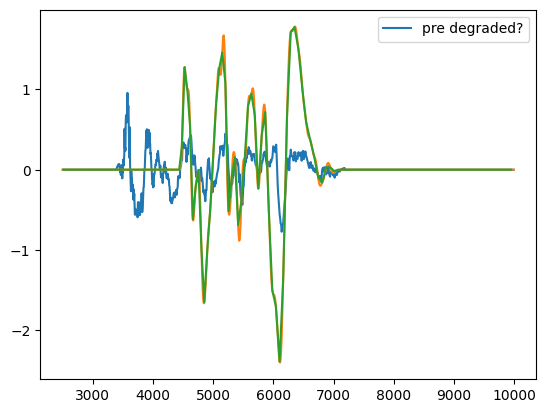

noise:  4.0
now clean
now lower res


In [ ]:
for i in range(0,10):
    noise_scale = i
    df_RPA_trn, df_RP_tst = main(noise_scale)
    continue
    Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_RPA_trn)
    Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_RP_tst)


    input_shape = Xtrn.shape[1:]
    model = get_model(input_shape, num_classes)
    #model.summary()
    #continue
    lr0 = 1e-5
    loss = CategoricalCrossentropy()
    acc = CategoricalAccuracy(name="ca")
    f1 = F1Score(num_classes=num_classes, average="macro", name="f1")

    optimizer = Nadam(learning_rate=lr0)
    model.compile(loss=loss, optimizer=optimizer, metrics=[acc, f1])

    early = callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="min",
        restore_best_weights=True,
    )
    file_log = f"../data/snr_test/{noise_scale}_history.log"
    logger = callbacks.CSVLogger(file_log, append=False)
    cbs = [early]#, logger]

    print("start training")
    history = model.fit(
        Xtrn,
        Ytrn,
        validation_data=(Xtst, Ytst),
        epochs=50,  # 10_000,
        batch_size=32,
        verbose=0,
        #callbacks=cbs,
    )

    loss_trn, ca_trn, f1_trn = model.evaluate(x=Xtrn, y=Ytrn, verbose=0)
    loss_tst, ca_tst, f1_tst = model.evaluate(x=Xtst, y=Ytst, verbose=0)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model loss ({noise_scale})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.yscale("log")
    plt.show()